# Game Score v0.2 Notebook

## Started 11/29/23 to update Game Score Calculation

### Improvments
- adds weight for scoring in close games (team +/- 1 goals)
- Adjusts SHOTS score, utilizes both CLose Shots & Even Strength shots 
- Uses +/- for TEAM score - old methodoligy didn't make any sense
- Adds more depth to PENALTY
    - differenciates and wieghts minor penalties and majors differently
    - GOAL but many too much to chew off right now
        - Uses opposing team's PP success rate to weight the PENALTY score
            - seems easy enough to calculate each teams past PP success but it changes from game to game
                


In [39]:
# Dependencies and Setup
import pandas as pd
import numpy as np
import sqlite3

## Connect to Database
path = '../data/db/Dec_11_Current_YTD_Game_Stats.db'
conn = sqlite3.connect(path)

# Check for tables
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")


# SHOT

In [40]:
# Use the advanced_metrics table to create a dataframe with shots (on_net, missed, blocked) in the EVEN and CLOSE situations

# Load the 'advanced_metrics_combined' table into a DataFrame excluding 'TOTAL' rows
df_amc = pd.read_sql("SELECT * FROM advanced_metrics WHERE player != 'TOTAL'", conn)

# Convert columns to numeric for calculations (replacing empty strings with 0)
columns_to_convert = ['EVEN_Saved', 'EVEN_Goals', 'EVEN_Miss', 'EVEN_Block', 'EVEN_Goals', 
                      'CLOSE_Saved', 'CLOSE_Miss', 'CLOSE_Block', 'CLOSE_Goals', 'CLOSE_Goals',
                        'D_Blocks']
for col in columns_to_convert:
    df_amc[col] = pd.to_numeric(df_amc[col].replace('', '0'))

# Create a new DataFrame with the columns we want to use
shots_df = df_amc[['Team', 'Player', 'Game_ID', 
                   'EVEN_Saved', 'EVEN_Miss', 'EVEN_Block', 'EVEN_Goals',
                   'CLOSE_Saved', 'CLOSE_Miss', 'CLOSE_Block', 'CLOSE_Goals',
                   'D_Blocks']]

# Creat SHOTS ON NET column (Saved + Goals)
shots_df['EVEN_On_Net'] = shots_df['EVEN_Saved'] + shots_df['EVEN_Goals']
shots_df['CLOSE_On_Net'] = shots_df['CLOSE_Saved'] + shots_df['CLOSE_Goals']


# ############ BLOCK TO CALCULATE THE WEIGHTED SHOTS SCORE ############

# SCORE = "CLOSE_On_Net * 0.1 + CLOSE_Miss * 0.08 + CLOSE_Block * 0.05 
#   + EVEN_On_Net * 0.1 + EVEN_Miss * 0.08 + EVEN_Block * 0.05 (NOT D_Blocks - Going to Use in TEAM COMPONANT)"

# Do the calualtions for the weighted shots score and add it to the DataFrame
shots_df['EVEN_Score'] = shots_df['EVEN_On_Net'] * 0.1 + shots_df['EVEN_Miss'] * 0.08 + shots_df['EVEN_Block'] * 0.05
shots_df['CLOSE_Score'] = shots_df['CLOSE_On_Net'] * 0.15 + shots_df['CLOSE_Miss'] * 0.1 + shots_df['CLOSE_Block'] * 0.08

# Add the EVEN and CLOSE scores together to get the total weighted shots score
shots_df['SHOT_Score'] = shots_df['EVEN_Score'] + shots_df['CLOSE_Score']


# shots_df.head()

C:\Users\Justin\AppData\Local\Temp\ipykernel_14128\1433447962.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shots_df['EVEN_On_Net'] = shots_df['EVEN_Saved'] + shots_df['EVEN_Goals']
C:\Users\Justin\AppData\Local\Temp\ipykernel_14128\1433447962.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shots_df['CLOSE_On_Net'] = shots_df['CLOSE_Saved'] + shots_df['CLOSE_Goals']
C:\Users\Justin\AppData\Local\Temp\ipykernel_14128\1433447962.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy

# FACEOFF

In [41]:
# Calulate Faceoff Score
# SCORE = "Faceoff_Wins * 0.075 - Faceoff_Losses * 0.075"

# Create a new DataFrame with the columns we want to use from player_stats table in the database
df_fo = pd.read_sql("SELECT Team, Player, Game_ID, FOW, FOL FROM player_stats", conn)

# Convert columns to numeric for calculations (replacing empty strings with 0)
columns_to_convert = ['FOW', 'FOL']
for col in columns_to_convert:
    df_fo[col] = pd.to_numeric(df_fo[col].replace('', '0'))

# Do the calualtions for the faceoff score and add it to the DataFrame
df_fo['FACEOFF_Score'] = df_fo['FOW'] * 0.075 - df_fo['FOL'] * 0.075

# Fil Nan values with 0
df_fo = df_fo.fillna(0)

df_fo.head()
# df_fo.info()


,Team,Player,Game_ID,FOW,FOL,FACEOFF_Score
0,Michigan State,Gavin O'Connell,2023-10-07-Lake Superior-Michigan State,0.0,0.0,0.0
1,Michigan State,Tommi Männistö,2023-10-07-Lake Superior-Michigan State,0.0,0.0,0.0
2,Michigan State,Maxim Štrbák,2023-10-07-Lake Superior-Michigan State,0.0,0.0,0.0
3,Michigan State,Artyom Levshunov,2023-10-07-Lake Superior-Michigan State,0.0,0.0,0.0
4,Michigan State,Patrick Geary,2023-10-07-Lake Superior-Michigan State,0.0,0.0,0.0


# TEAM
## +/- *.25 + Blocked Shots * .1

In [42]:
# Calculate TEAM Score 
# Plus-Minus + Defensive Blocks

# Get plus_minus from player_stas table
df_plus_minus = pd.read_sql("SELECT * FROM player_stats WHERE player != 'TOTAL'", conn)
# Simplify the DataFrame to only the columns we need
df_plus_minus = df_plus_minus[['Team', 'Player', 'Game_ID', 'plus_minus']]

# Get Defensive block column from previous dataframe (df_amc)
df_blocks = df_amc[['Team', 'Player', 'Game_ID', 'D_Blocks']]

# Merge the two DataFrames together
df_team = pd.merge(df_plus_minus, df_blocks, how='outer', on=['Team', 'Player', 'Game_ID'])

# Fill any NaN values with 0
df_team = df_team.fillna(0)
# Convert D_Blocks to to int
df_team['D_Blocks'] = df_team['D_Blocks'].astype(int)
# Conver plus_minus to int
df_team['plus_minus'] = df_team['plus_minus'].astype(int)



df_team['TEAM_Score'] = df_team['plus_minus'] * 0.25 + df_team['D_Blocks'] * 0.1

# df_team.sample(25)
# df_team.info()

# df_blocks.info()

# Penalty

In [43]:
# SUB FUNCTION To calculate the the Overall Power Play Success Rate for entire dataset
# - Used to Weight the PENALTY_SCORE

# Count the total number of Power Play (PP) goals from the scoring_summary table.
pp_goals_count = cursor.execute("SELECT COUNT(*) FROM scoring_summary WHERE PP != '';").fetchone()[0]
# Count the total number of Power Plays from the penalty_summary table.
total_pp_count = cursor.execute("SELECT COUNT(*) FROM penalty_summary;").fetchone()[0]
# Calculate the Power Play success rate.
pp_success_rate = pp_goals_count / total_pp_count

## OVERALL NCAA WIDE POWER PLAY SUCCESS RATE TO USE IN FACTOR
print(f'Overall PP % All Games: {pp_success_rate}')


Overall PP % All Games: 0.25060346719332893


In [44]:
# Use Penalty Summary table to get every individual penalty incident
## Count and differentiate between minor and major penalties

# Load the 'penalty_summary' table into a DataFrame
df_pen = pd.read_sql("SELECT * FROM penalty_summary", conn)

# Create Two Columns to count the number of minor and major penalties
df_pen['Minor_Pen'] = np.where(df_pen['Pen_Length'] == '2', 1, 0)
df_pen['Major_Pen'] = np.where(df_pen['Pen_Length'] == '5', 1, 0)

# Group by player, team, and game_id to get the total number of minor and major penalties
df_pen = df_pen.groupby(['Player', 'Team', 'Game_ID']).agg({'Minor_Pen': 'sum', 'Major_Pen': 'sum'}).reset_index()

# Calulate the Penalty Score
# SCORE = "Penalty_Score = Minor_Pen * pp_succes_rate + Major_Pen * pp_success_rate * 2.5"
df_pen['PENALTY_Score'] = df_pen['Minor_Pen'] * pp_success_rate + df_pen['Major_Pen'] * pp_success_rate * 2.5

# df_pen.head(50)
# df_pen.info()

# # How many players have a major penalty?
# df_pen[df_pen['Major_Pen'] > 0].count()

# SCORING

### Method
- use the scoring_summary table to get all scoring incidents
- Identify Scoring Incidents in CLOSE Games - 1 goal game +/-
    - Store as C_Goal, C_Asst1, C_Asst2
- Indentify Scoring that was shorthanded (PP Column will be 'SH')
    - Store as SH_Goal, SH_Asst1, SH_Asst2


In [45]:
# Create SCORING Score using the scoring_summary table

# Load the 'scoring_summary' table into a DataFrame
# df_scoring = pd.read_sql("SELECT * FROM scoring_summary", conn)


In [46]:
# Adjusting the code to correctly classify each goal into one of the three categories
from collections import defaultdict
# Reset the dataframe for reprocessing
df_scoring_updated =  pd.read_sql("SELECT * FROM scoring_summary", conn)

# # Fill NaN values with empty strings in Assists columns
# df_scoring_updated['Assist1'].fillna('NONE', inplace=True)
# df_scoring_updated['Assist2'].fillna('NONE', inplace=True)

# Preparing to track scores for each game
game_scores = defaultdict(lambda: {'teams': [], 'scores': {}})
teams_per_game = df_scoring_updated.groupby('Game_ID')['Team'].unique()

# Rename Player Column to Goal
df_scoring_updated.rename(columns={'Player': 'Goal'}, inplace=True)

# Function to update and check scores for close game situation
def update_and_check_score(row, game_scores):
    # Skip if it's a shorthanded goal
    if row['PP'] == 'SH':
        return False

    game_id = row['Game_ID']
    team = row['Team']

    # Ensure the game has exactly two teams
    if len(game_scores[game_id]['teams']) != 2:
        return False  # Cannot determine close game status without knowing both teams

    # Identify the other team
    other_team = game_scores[game_id]['teams'][0] if team != game_scores[game_id]['teams'][0] else game_scores[game_id]['teams'][1]

    # Update the score for the scoring team
    game_scores[game_id]['scores'][team] += 1

    # Calculate score difference
    score_diff = abs(game_scores[game_id]['scores'][team] - game_scores[game_id]['scores'][other_team])

    # Check if it's a close game situation
    return score_diff <= 1

# Initialize score tracking and process each scoring incident
for game_id, teams in teams_per_game.items():
    if len(teams) == 2:  # Ensure only games with two teams are processed
        game_scores[game_id]['teams'] = teams.tolist()
        game_scores[game_id]['scores'] = {team: 0 for team in teams}

df_scoring_updated['CLOSE'] = df_scoring_updated.apply(lambda row: update_and_check_score(row, game_scores), axis=1)
df_scoring_updated['SHORT'] = df_scoring_updated['PP'] == 'SH'
# Create New Column to identify 'LOW Goals' - If Close_Game = False and SH_Scoring = False
# df_scoring_updated['Low_Goals'] = df_scoring_updated.apply(lambda x: 1 if not x['Close_Game'] and not x['SH_Scoring'] else 0, axis=1)

# Select only the columns we will use later
df_scoring_updated = df_scoring_updated[['Team', 'Game_ID', 'Goal', 'Assist1', 'Assist2', 'CLOSE', 'SHORT']]

df = df_scoring_updated

# OUTPUT CSV to TEMP folder for inspection
df.to_csv('../TEMP/df_scoring_updatedXX.csv')


# df.sample(5)




In [47]:
## GOAL FOR THE CODE - Create a DataFrame with the Game_ID, Team, Player_Name, Goals, Assists, and Close_Game columns for each of the three situations 
### The Game situations are SHORETHANDED, CLOSE, and NOT_CLOSE
# IF SHORT = TRUE Then The Goal and asissts are weighted differently
# IF SHORT is FALSE and CLOSE is TRUE then the Goal and Assists are weighted differently
# IF SHORT is FALSE and CLOSE is FALSE then the Goal and Assists are weighted differently



In [48]:

# Function to count occurrences of each player for each statistic, including the NOT situation
def count_player_stats_including_not(df, player_column):
    # Creating a 'NOT' column indicating whether the situation is neither SHORT nor CLOSE
    df['NOT'] = ~(df['SHORT'] | df['CLOSE'])

    # Preparing the dataset for counting
    stats_df = df.melt(id_vars=['Game_ID', 'Team', player_column], 
                       value_vars=['SHORT', 'CLOSE', 'NOT'], 
                       var_name='Situation', value_name='Count')

    # Filtering only true values and counting occurrences
    stats_df = stats_df[stats_df['Count']].groupby(['Game_ID', 'Team', player_column, 'Situation']).size().reset_index(name='Counts')

    return stats_df

# Applying the modified function for Goal, Assist1, and Assist2
goal_stats = count_player_stats_including_not(df, 'Goal')
assist1_stats = count_player_stats_including_not(df, 'Assist1')
assist2_stats = count_player_stats_including_not(df, 'Assist2')

# Renaming columns for clarity
goal_stats.rename(columns={'Goal': 'Player_Name', 'Counts': 'Goal_Count'}, inplace=True)
assist1_stats.rename(columns={'Assist1': 'Player_Name', 'Counts': 'Assist1_Count'}, inplace=True)
assist2_stats.rename(columns={'Assist2': 'Player_Name', 'Counts': 'Assist2_Count'}, inplace=True)

# Merging the DataFrames
merged_stats = pd.concat([goal_stats, assist1_stats, assist2_stats])

# Pivoting the table to get the final format
final_df_with_not = merged_stats.pivot_table(index=['Game_ID', 'Team', 'Player_Name'], 
                                             columns='Situation', 
                                             values=['Goal_Count', 'Assist1_Count', 'Assist2_Count'], 
                                             fill_value=0).reset_index()

# Flattening the multi-level column headers
final_df_with_not.columns = ['_'.join(col).strip() for col in final_df_with_not.columns.values]

# Displaying the refactored DataFrame
final_df_with_not.head()

# Rename to final_df
final_df = final_df_with_not

,Assist1_Count_CLOSE,Assist1_Count_NOT,Assist1_Count_SHORT,Assist2_Count_CLOSE,Assist2_Count_NOT,Assist2_Count_SHORT,Goal_Count_CLOSE,Goal_Count_NOT,Goal_Count_SHORT,Total_Points
count,6327.000000,6327.000000,6327.000000,6327.000000,6327.000000,6327.000000,6327.000000,6327.000000,6327.000000,6327.000000
mean,0.248933,0.192034,0.009483,0.209104,0.157737,0.004267,0.259365,0.207839,0.014383,1.303145
std,0.459716,0.428527,0.096926,0.422710,0.394913,0.067572,0.471338,0.449064,0.121698,0.592738
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,3.000000,3.000000,1.000000,3.000000,3.000000,2.000000,3.000000,3.000000,2.000000,5.000000


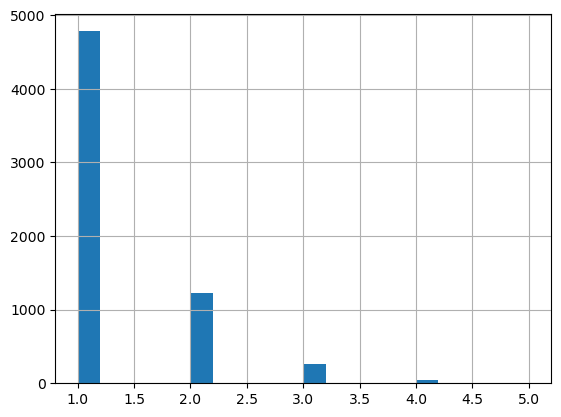

In [49]:
## Calculate the Total Points for each player to QC the data

# Create a new column to calculate the total points for each player
final_df['Total_Points'] = final_df['Goal_Count_CLOSE'] + final_df['Goal_Count_SHORT'] +final_df['Goal_Count_NOT'] \
    + final_df['Assist1_Count_CLOSE'] + final_df['Assist1_Count_SHORT'] + final_df['Assist1_Count_NOT'] \
        + final_df['Assist2_Count_CLOSE'] + final_df['Assist2_Count_SHORT'] + final_df['Assist2_Count_NOT']

# Sort the DataFrame by Total_Points
# final_df.sort_values(by='Total_Points', ascending=False).head(25)

# # Reorder The columns so the Total_Points is the first column
# final_df = final_df[['Total_Points', 'Game_ID', 'Team', 'Player_Name', 'Goal_Count_CLOSE', 'Goal_Count_SHORT', 'Assist1_Count_CLOSE', 'Assist1_Count_SHORT', 'Assist2_Count_CLOSE', 'Assist2_Count_SHORT']]

# Histogram of Total Points
final_df['Total_Points'].hist(bins=20)

# Value Counts of Total Points
final_df['Total_Points'].value_counts().sort_index()

# Describe the entire dataframe
final_df.describe()

In [50]:
final_df.columns

Index(['Game_ID_', 'Team_', 'Player_Name_', 'Assist1_Count_CLOSE',
       'Assist1_Count_NOT', 'Assist1_Count_SHORT', 'Assist2_Count_CLOSE',
       'Assist2_Count_NOT', 'Assist2_Count_SHORT', 'Goal_Count_CLOSE',
       'Goal_Count_NOT', 'Goal_Count_SHORT', 'Total_Points'],
      dtype='object')

In [51]:
# Rename the Game_ID, Team, and Player_Name to drop the _ at the end
final_df.rename(columns={'Game_ID_': 'Game_ID', 'Team_': 'Team', 'Player_Name_': 'Player_Name'}, inplace=True)
final_df.columns

Index(['Game_ID', 'Team', 'Player_Name', 'Assist1_Count_CLOSE',
       'Assist1_Count_NOT', 'Assist1_Count_SHORT', 'Assist2_Count_CLOSE',
       'Assist2_Count_NOT', 'Assist2_Count_SHORT', 'Goal_Count_CLOSE',
       'Goal_Count_NOT', 'Goal_Count_SHORT', 'Total_Points'],
      dtype='object')

In [52]:
### Calculate SCORING Score

score_df = final_df

# Fill Nan values with 0
# score_df = score_df.fillna(0)

non_int_cols = ['Player_Name', 'Team', 'Game_ID']

# Convert all columns to int except for non_int_cols
for col in score_df.columns:
    if col not in non_int_cols:
        score_df[col] = score_df[col].astype(int)

# Calculate the Scoring Score
## Factors - GOALS = .555, ASSIST1 = .455, ASSIST2 = .355
## CLOSE GAME MULTIPLIER = 1.5
## SH GOAL MULTIPLIER = 1.75

## Rename the columns to match the expected Names
# dict = {''}


############ OLD COLUMN NAMES ############
score_df['SCORING_Score'] = score_df['Goal_Count_CLOSE'] * 1.5 * 0.555 + score_df['Assist1_Count_CLOSE'] * 1.5 * 0.455 + score_df['Assist2_Count_CLOSE'] * 1.5 * 0.355 + \
                            score_df['Goal_Count_SHORT'] * 1.75 * 0.555 + score_df['Assist1_Count_SHORT'] * 1.75 * 0.455 + score_df['Assist2_Count_SHORT'] * 1.75 * 0.355 + \
                            score_df['Goal_Count_NOT'] * 0.555 + score_df['Assist1_Count_NOT'] * 0.455 + score_df['Assist2_Count_NOT'] * 0.355

# Rename Player_Name to Player
score_df.rename(columns={'Player_Name': 'Player'}, inplace=True)

# score_df.head()



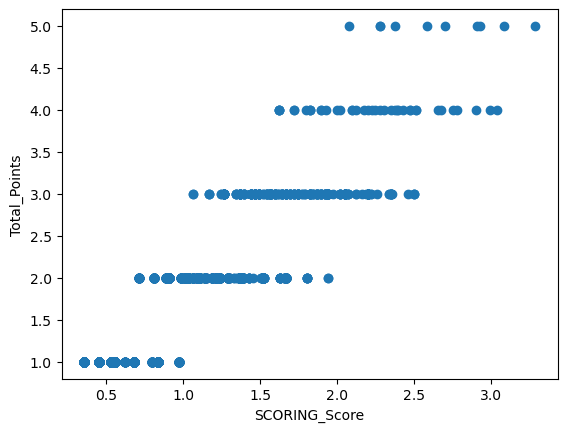

In [53]:
## Examine Output 

# Histogram of Scoring Score
# score_df['SCORING_Score'].hist()


# score_df.info()

# Sort by Scoring Score and show top 25
# score_df.sort_values(by='SCORING_Score', ascending=False).head(25)

# Value Counts for Short_Assist2
# score_df['Short_Assist2'].value_counts()

# Plot Score vs Total Points
import matplotlib.pyplot as plt

plt.scatter(score_df['SCORING_Score'], score_df['Total_Points'])
plt.xlabel('SCORING_Score')
plt.ylabel('Total_Points')
# Show the plot
plt.show()

## Combine to single dataframe

In [54]:
### COMBINE ALL THE DATAFRAMES TOGETHER

# Merge the shots_df and df_fo DataFrames together
df_combined = pd.merge(shots_df, df_fo, how='outer', on=['Team', 'Player', 'Game_ID'])

# Merge the df_combined and df_team DataFrames together
df_combined = pd.merge(df_combined, df_team, how='outer', on=['Team', 'Player', 'Game_ID'])

# Merge the df_combined and df_pen DataFrames together
df_combined = pd.merge(df_combined, df_pen, how='outer', on=['Team', 'Player', 'Game_ID'])

# Merge the df_combined and score_df DataFrames together
df_combined = pd.merge(df_combined, score_df, how='outer', on=['Team', 'Player', 'Game_ID'])

# Fill any NaN values with 0
df_combined = df_combined.fillna(0)

# Filter To Just The SCORE Columns
keep_col = ['Team', 'Player', 'Game_ID', 'SCORING_Score', 'SHOT_Score', 'FACEOFF_Score', 'TEAM_Score', 'PENALTY_Score']
df_combined = df_combined[keep_col]

# Calulate the TOTAL Score
## SCORE = "TOTAL_Score = SHOT_Score + FACEOFF_Score + TEAM_Score - PENALTY_Score"
df_combined['TOTAL_Score'] = df_combined['SCORING_Score'] \
    + df_combined['SHOT_Score'] + df_combined['FACEOFF_Score'] \
        + df_combined['TEAM_Score'] - df_combined['PENALTY_Score']

# df_combined.head(10)

# df_combined.sample(10)
# # df_combined.info()

# df_combined.describe()

In [55]:
# Save a CSV to the TEMP folder for inspection
df_combined.to_csv('../TEMP/GAME_SCORE_V2.csv')

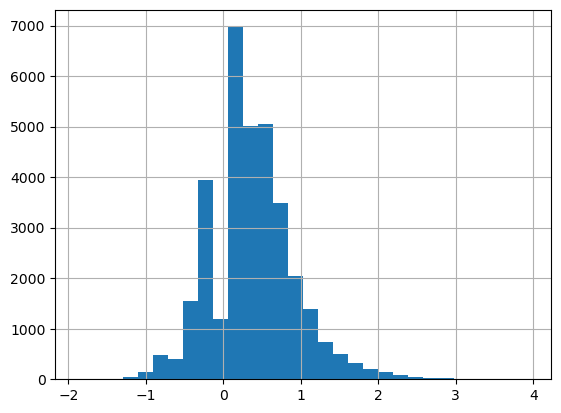

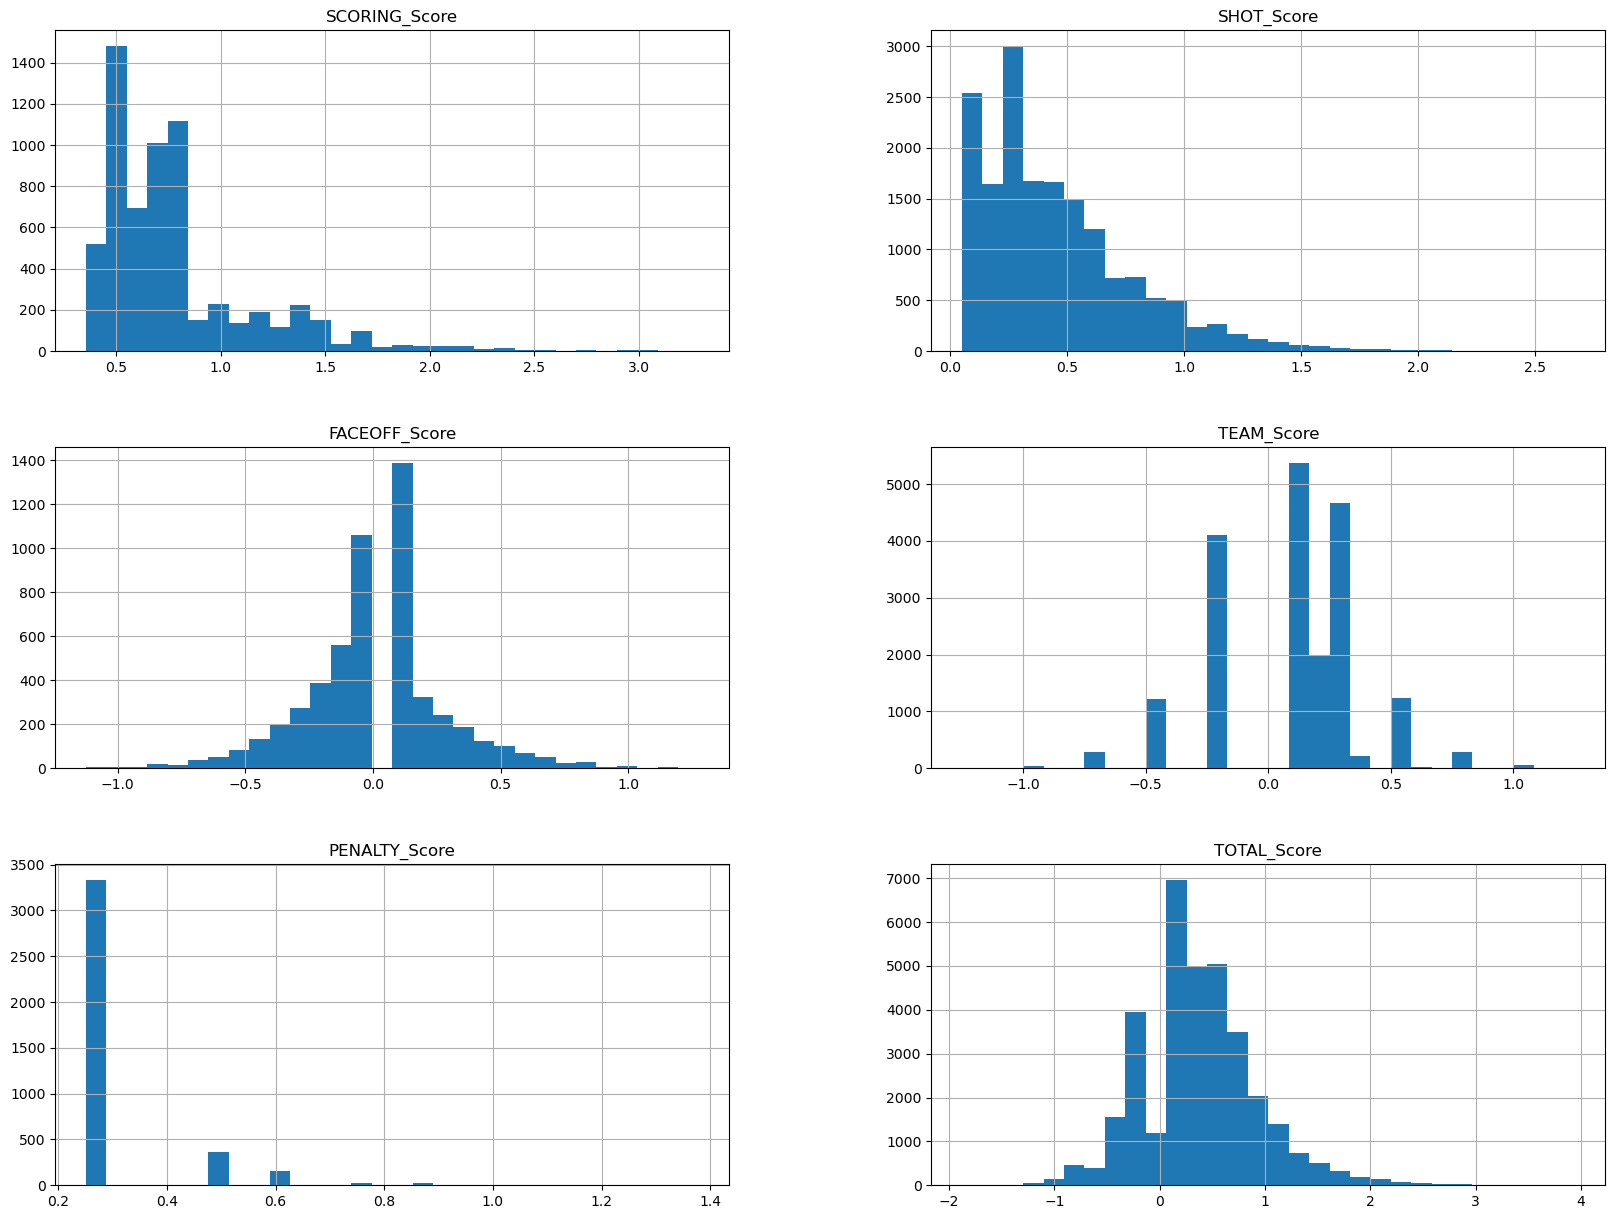

In [56]:
# Replace all 0s with NaN
df_combined = df_combined.replace(0, np.nan)


# Score Distribution
df_combined['TOTAL_Score'].describe()

 # Histogram Plot of Score Distribution
df_combined['TOTAL_Score'].hist(bins=30)

# Histograms of all the scores
df_combined.hist(bins=30, figsize=(20,15))

# Replace all 0s with NaN
df_combined = df_combined.replace(0, np.nan)

# Drop all NaN values



## Add Goal and Assist 
### Last 5 games and total

In [57]:
### SQL to Create the Goal - Assist table with LAST5GAMES and TOTALS

# Create a new DataFrame with the columns we want to use from player_stats table in the database
# df_player_stats = pd.read_sql("SELECT Team, Player, Game_ID, Goals, Assists FROM player_stats", conn)

## Select the 5 most recent games for each player
# Create a new DataFrame with the columns we want to use from player_stats table in the database



## Report Top Stars of the Night & Weekend

### Output a

In [58]:
# ## Output a CSV of the Top performers of the most recent game

# ####################################
# ##### INPUTDATE RANGE FOR QUERY ####

# range_start = '2023-12-01'
# range_end = '2023-12-04'

# ####################################


# # Query the database date range
# df_recent = pd.read_sql(f"SELECT * FROM game_score_v2 WHERE Game_ID >= '{range_start}' AND Game_ID <= '{range_end}' ORDER BY TOTAL_Score DESC", conn)

# # Sort Players by Total AGS Score
# df_recent = df_recent.sort_values(by='TOTAL_Score', ascending=False)

# # Reset the index
# df_recent = df_recent.reset_index(drop=True)

# # Add a Rank column
# df_recent['Rank'] = df_recent.index + 1

# # Reorder the columns -['Team', 'Player', 'Game_ID', 'TOTAL_Score', 'SCORING_Score', 'SHOT_Score', 'FACEOFF_Score', 'TEAM_Score', 'PENALTY_Score']
# df_recent = df_recent[['Rank', 'Team', 'Player', 'Game_ID', 'TOTAL_Score', 'SCORING_Score', 'SHOT_Score', 'FACEOFF_Score', 'TEAM_Score', 'PENALTY_Score']]

# # Save a CSV to the TEMP folder for inspection with date range
# df_recent.to_csv(f'../TEMP/GAME_SCORE_V2_{range_start}_{range_end}.csv')




# # Display the top 25
# df_recent.head(25)









# OutPut CSV Files FOr Each Team 

## Code started in Original Game Score workbook

In [59]:
# Rename datafram
df = df_combined

# Take out those annoying character if there are any
# Replace non-breaking spaces with regular spaces in the Player column of compiled_df
df['Player'] = df['Player'].str.replace('\xa0', ' ')
# Flatten the rows with matching Player
df = df.groupby(['Team', 'Player', 'Game_ID']).sum().reset_index()

# Rename TOTAL_Score to Game_Score
df.rename(columns={'TOTAL_Score': 'Game_Score'}, inplace=True)

# Generate team-specific tables using a pivot table
team_tables = {}

unique_teams = df['Team'].unique()

for team in unique_teams:
    team_df = df[df['Team'] == team]
    pivot_table = team_df.pivot(index='Player', columns='Game_ID', values='Game_Score')
    team_tables[team] = pivot_table


# Print List of Teams
unique_teams


# Fill NaN values with 0
for team in unique_teams:
    team_tables[team] = team_tables[team].fillna(0)

In [60]:
# Clean up the column names of all the team tables
# Want to remove:
# - all digits
# - all Dashes
# - the teams name

# Create a dictionary to store the new column names
new_column_names = {}

# Loop through each team table
for team in unique_teams:
    # Create a list to store the new column names
    new_column_names[team] = []
    
    # Loop through each column name
    for column_name in team_tables[team].columns:

        # Remove all digits from the column name
        new_column_name = ''.join([i for i in column_name if not i.isdigit()])
        
        # Remove all dashes from the column name
        new_column_name = new_column_name.replace('-', '')
        
        # Remove the team name from the column name
        new_column_name = new_column_name.replace(str(team), '')
        
        # Add the new column name to the list
        new_column_names[team].append(new_column_name)
    
    # Assign the new column names to the team table
    team_tables[team].columns = new_column_names[team]

## Add the team name to each table
for team in unique_teams:
    team_tables[team]['Team'] = team

# Player's of the Week/ Night

In [61]:
## Top 5 Players from all teams for the last game played



# Output Raw CSVs to directory for each team

In [62]:
## Save each table to a csv with the team name and the season

## Folder to save to
# folder_path = '../TEMP/2022_csv_dump/' # Folder for 2022
folder_path = '../TEMP/YTD_GAME_SCORE_V2_dump/' # Folder for 2023 Year To Date

## Loop through each team and save the csv
for team in unique_teams:
    team_tables[team].to_csv(f'{folder_path}{team}_GAME_SCORES.csv')





## TESTING AND R&D

### Normalize the player score in each game against the rest of their team (or against all players from both teams?) to a scale of 0-10 or 0-1. Would be interesting way to look at things - try that next
